# RECEIPT SEGMENTATION 
_Christophe LUTZ, on 26/02/2024_

## 1) Introduction 
Welcome to the Receipt Segmentation Notebook! In this notebook, we delve into the intricate process of segmenting receipts within images, a crucial step towards enhancing the efficiency and accuracy of subsequent receipt processing tasks. Receipt segmentation serves as the foundation for various downstream applications, particularly Optical Character Recognition (OCR), by standardizing the input and isolating relevant regions of interest.

In [22]:
import cv2
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import scipy
from sklearn.cluster import AgglomerativeClustering
root_dir = Path('src').resolve().parent.parent
print(f'{root_dir=}')

root_dir=WindowsPath('C:/Users/PC-NH90/Desktop/receipt/receipt')


In [1]:
def resize(img):
    ''' Resizes the image so that it fits in the screen '''
    # Define the maximum width and height for display
    max_width = 800
    max_height = 600

    # Get the dimensions of the image
    height, width, _ = img.shape

    # Calculate the scaling factor based on the larger dimension
    scale_factor = max(max_width / width, max_height / height)

    # Resize the image while maintaining aspect ratio
    resized_image = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
    return resized_image

def sort_points(points):
    ''' Splits array of points in one of the four quadrant'''
    points = np.array(points)
    is_left = points[:,0]<np.median(points[:,0])
    is_top = points[:,1]<np.median(points[:,1])

    return {
        'top_left': points[np.bitwise_and(is_left, is_top)],
        'top_right': points[np.bitwise_and(~is_left, is_top)],
        'bottom_left': points[np.bitwise_and(is_left, ~is_top)],
        'bottom_right': points[np.bitwise_and(~is_left, ~is_top)]
    }

def show(img):
    ''' Displays an image in separate window'''
    pil_image = Image.fromarray(img) 
    pil_image.show()

def display_result(img, title):
    ''' Displays several images in a row'''
    plt.figure(figsize=(10, 5))
    n = len(img)
    for i, im in enumerate(img):
        plt.subplot(1, n+1, i+1)
        plt.imshow(im)
        plt.title(title[i])

    plt.tight_layout()
    plt.show()  


## 2)Thresholding and Contour-Based Segmentation Techniques

In this section, we explore a pipeline utilizing OpenCV for receipt segmentation. Let's break down each step:

* __Grayscale Conversion__: The image is converted from color to grayscale, reducing data volume while retaining essential information. This step is particularly effective as most receipt backgrounds are predominantly white.

* __Blur Operation__: A blurring filter is applied to the grayscale image. This process helps eliminate minor details while preserving prominent features, effectively smoothing out text and background noise.

* __Thresholding__: The image is transformed into a binary representation (black and white) based on a specified threshold value. This binary format is well-suited for subsequent detection algorithms, simplifying the segmentation process.

* __Contour Detection__: Utilizing contouring algorithms, the system identifies and delineates the boundaries of objects within the image. This step is instrumental in isolating the receipt from its surroundings, facilitating further processing.

* __Warping__: The image undergoes a warping transformation to flatten its content. This operation is particularly useful for receipts, ensuring a consistent and uniform representation for subsequent analysis.

By employing these techniques sequentially, we establish a robust pipeline for receipt segmentation, laying the groundwork for efficient and accurate extraction of relevant information.

In [2]:
def basic_receipt_segmentation(img, improved_version=False):

    # convert img to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # blur image
    blur = cv2.GaussianBlur(gray, (3,3), 0)

    # do otsu threshold on gray image
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    # apply morphology
    kernel = np.ones((7,7), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

    # get largest contour
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    area_thresh = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > area_thresh:
            area_thresh = area
            big_contour = c

    # draw white filled largest contour on black just as a check to see it got the correct region
    page = np.zeros_like(img)
    cv2.drawContours(page, [big_contour], 0, (255,255,255), -1)

    # get perimeter and approximate a polygon
    peri = cv2.arcLength(big_contour, True)
    corners = cv2.approxPolyDP(big_contour, 0.04 * peri, True)

    if improved_version:
        sorted_corners = sort_points(corners.squeeze())
        corners = np.expand_dims(
            np.vstack([sorted_corners['top_right'],sorted_corners['top_left'],sorted_corners['bottom_left'],sorted_corners['bottom_right']]),
            axis=1)
    # draw polygon on input image from detected corners
    polygon = img.copy()
    cv2.polylines(polygon, [corners], True, (0,0,255), 1, cv2.LINE_AA)
    # Alternate: cv2.drawContours(page,[corners],0,(0,0,255),1)

    # print the number of found corners and the corner coordinates
    # They seem to be listed counter-clockwise from the top most corner
    # print(len(corners))
    # print(corners)

    # for simplicity get average of top/bottom side widths and average of left/right side heights
    # note: probably better to get average of horizontal lengths and of vertical lengths
    width = 0.5*( (corners[0][0][0] - corners[1][0][0]) + (corners[3][0][0] - corners[2][0][0]) )
    height = 0.5*( (corners[2][0][1] - corners[1][0][1]) + (corners[3][0][1] - corners[0][0][1]) )
    width = np.intp(width)
    height = np.intp(height)

    # reformat input corners to x,y list
    icorners = []
    for corner in corners:
        pt = [ corner[0][0],corner[0][1] ]
        icorners.append(pt)
    icorners = np.float32(icorners)

    # get corresponding output corners from width and height
    ocorners = [ [width,0], [0,0], [0,height], [width,height] ]
    ocorners = np.float32(ocorners)

    # get perspective tranformation matrix
    M = cv2.getPerspectiveTransform(icorners, ocorners)

    # do perspective 
    warped = cv2.warpPerspective(img, M, (width, height))

    return morph, page, polygon, warped


The function is initially applied to a sample image sourced from the internet to demonstrate its functionality.

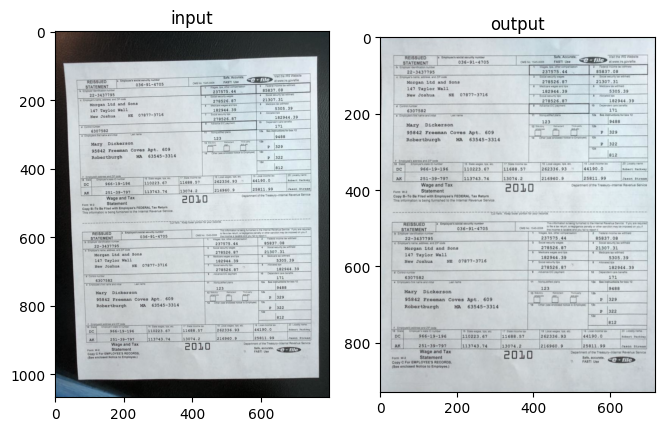

In [25]:
filename = root_dir / r'data\form.jpg'

# read image
img = resize(cv2.imread(str(filename)))
warped = basic_receipt_segmentation(img)[-1]
display_result((img, warped), ('input', 'output'))

The function is initially applied to sample images collected from the internet as well as from my phone, encompassing a diverse range of backgrounds and dimensions. 

While the basic function handles simple images effectively, enhancements have been made to ensure robustness against variations in the ordering of the output produced by the approxPolyDP function.

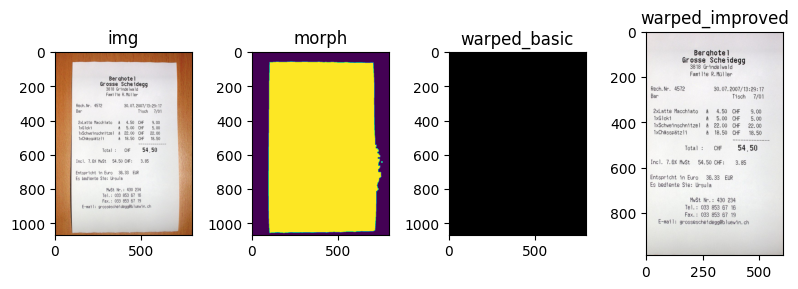

In [41]:
filename = root_dir / r'data\simple.jpg'

# read image
img = cv2.cvtColor(resize(cv2.imread(str(filename))), cv2.COLOR_BGR2RGB)
morph, _, _, warped = basic_receipt_segmentation(img)
_, _, _, warped_improved = basic_receipt_segmentation(img, improved_version=True)
display_result((img, morph, warped, warped_improved),('img', 'morph', 'warped_basic', 'warped_improved'))

In addition, more complex scenarios are now addressed, where backgrounds exhibit richer textures and the receipt itself may be subject to rotation or skewing. This expanded scope enables the function to handle a wider array of real-world scenarios, ensuring its applicability across diverse receipt images.

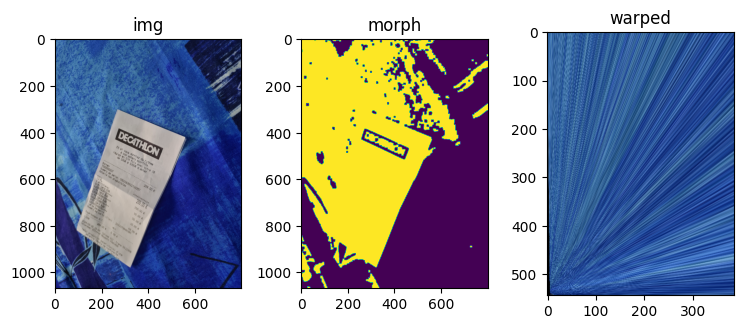

In [27]:
filename = root_dir / r'data\20240216_155137.jpg'

# read image
img = resize(cv2.imread(str(filename)))
morph, _, _, warped = basic_receipt_segmentation(img, improved_version=True)
display_result((img, morph, warped),('img', 'morph', 'warped', 'warped_improved'))

To tackle backgrounds with rich textures, coarse blurring could have been a potential solution. However, our approach pivoted towards employing a thresholding technique based on the characteristic white color of paper, which proved highly effective. The subsequent function incorporates both manual thresholding and a threshold learned from clustering.

It's worth noting that the function meticulously ensures the returned corners form a quadrilateral contour. This is achieved through iterative execution of the approxPolyDP function, leveraging scipy's bisect module for enhanced efficacity.

In [6]:
def advanced_receipt_segmentation(img_in, cluster_based_threshold=False):
    img = cv2.cvtColor(img_in,cv2.COLOR_RGB2GRAY)
    img = np.float32(img)

    # pil_image = Image.fromarray(img) 
    # pil_image.show() 

    img = cv2.GaussianBlur(img, (21,21), 0)
    img = cv2.convertScaleAbs(img)
    # img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    if cluster_based_threshold:
        downsampling_factor = 4
        img = cv2.resize(img, (0, 0), fx=1/downsampling_factor, fy=1/downsampling_factor)
        X = img.flatten()[:, np.newaxis]
        clustering = AgglomerativeClustering(n_clusters=2)
        cluster= clustering.fit_predict(X)
        cluster2center = {}
        for label in np.unique(cluster):
            cluster2center[label] = np.median(X[cluster == label], axis=0)[0]

        img_cluster = cv2.convertScaleAbs(np.vectorize(cluster2center.get)(cluster.reshape(img.shape)))
        threshold = np.max(img_cluster)-1
        img = cv2.threshold(img_cluster, threshold, 255, cv2.THRESH_BINARY)[1]
        img = cv2.resize(img, (0, 0), fx=downsampling_factor, fy=downsampling_factor, interpolation=cv2.INTER_NEAREST)
    else:
        threshold = 145
        img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)[1]
    print(f'{threshold=}')
    

    # kernel = np.ones((15,15), np.uint8)
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    # pil_image = Image.fromarray(img) 
    # pil_image.show() 

    # get largest contour
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    area_thresh = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > area_thresh:
            area_thresh = area
            big_contour = c

    # cv2.drawContours(img_in, contours, -1, (0,255,0), 3)

    # draw white filled largest contour on black just as a check to see it got the correct region

    peri = cv2.arcLength(big_contour, True)
    f = lambda frac : len(cv2.approxPolyDP(big_contour, frac * peri, True)) - 4
    frac = scipy.optimize.bisect(f, 0.001, 0.1)
    corners = cv2.approxPolyDP(big_contour, frac * peri, True)
    
    sorted_corners = sort_points(corners.squeeze())
    corners = np.expand_dims(
        np.vstack([sorted_corners['top_right'],sorted_corners['top_left'],sorted_corners['bottom_left'],sorted_corners['bottom_right']]),
        axis=1)
    
    # print(len(corners))
    cv2.polylines(img_in, [corners], True, (0,0,255), 1, cv2.LINE_AA)

    width = ( (corners[0][0][0] - corners[1][0][0]) + (corners[3][0][0] - corners[2][0][0]) )
    height =( (corners[2][0][1] - corners[1][0][1]) + (corners[3][0][1] - corners[0][0][1]) )
    # print(f'{width,height=}')
    # width = width/height*1200
    # height = 1200
    width = np.intp(width)
    height = np.intp(height)

    # reformat input corners to x,y list
    icorners = []
    for corner in corners:
        pt = [ corner[0][0],corner[0][1] ]
        icorners.append(pt)
    icorners = np.float32(icorners)

    # get corresponding output corners from width and height
    ocorners = [ [width,0], [0,0], [0,height], [width,height] ]
    ocorners = np.float32(ocorners)

    # get perspective tranformation matrix
    M = cv2.getPerspectiveTransform(icorners, ocorners)

    # do perspective 
    img_out = cv2.warpPerspective(img_in, M, (width, height))

    if width>height:
        img_out = cv2.rotate(img_out, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if cluster_based_threshold:
        return img_out, img_cluster
    else:
        return img_out

threshold=145


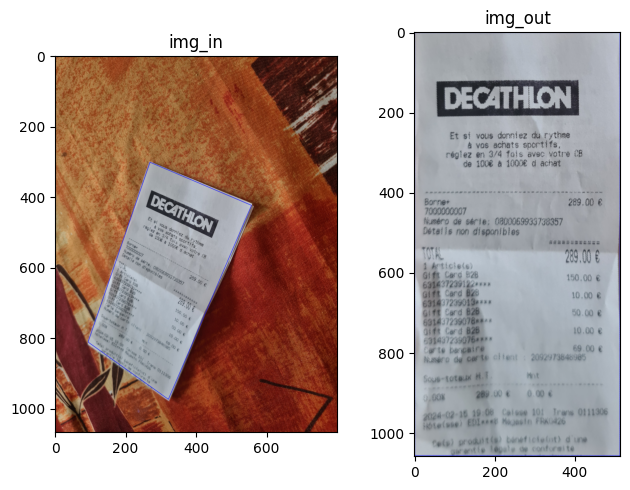

In [28]:
filename = root_dir / r'data\20240216_155137.jpg'

img_in = cv2.cvtColor(resize(cv2.imread(str(filename))),cv2.COLOR_BGR2RGB)
img_out = advanced_receipt_segmentation(img_in)
display_result((img_in, img_out),('img_in', 'img_out'))

threshold=145


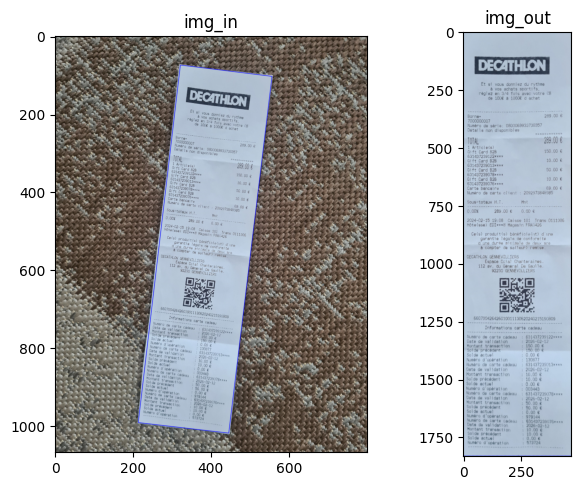

In [29]:
filename = root_dir / r'data\20240216_155156.jpg'

img_in = cv2.cvtColor(resize(cv2.imread(str(filename))),cv2.COLOR_BGR2RGB)
img_out = advanced_receipt_segmentation(img_in)
display_result((img_in, img_out),('img_in', 'img_out'))

The clustering-based thresholding method implements agglomerative hierarchical clustering into two sets, aiming to distinguish between the background and the paper. To manage computational and memory complexities effectively, a downsampling step is initially executed, followed by an upsampling operation after clustering. This approach ensures both numerical efficiency and memory optimization, enabling robust segmentation performance while accommodating varying computational resources.

threshold=188


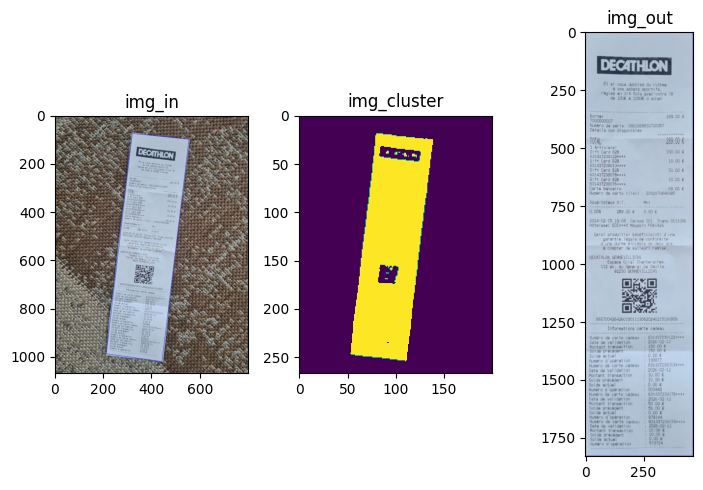

In [30]:
filename = root_dir / r'data\20240216_155156.jpg'

img_in = cv2.cvtColor(resize(cv2.imread(str(filename))),cv2.COLOR_BGR2RGB)
img_out, img_cluster = advanced_receipt_segmentation(img_in, True)
display_result((img_in, img_cluster, img_out),('img_in', 'img_cluster', 'img_out'))

threshold=145


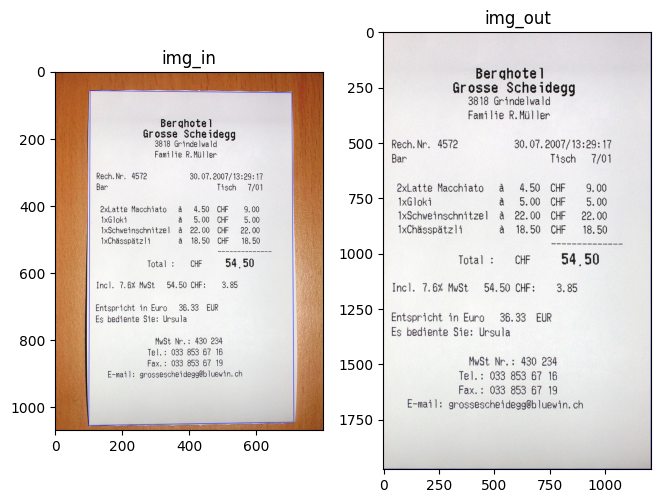

In [31]:
filename = root_dir / r'data\simple.jpg'

img_in = cv2.cvtColor(resize(cv2.imread(str(filename))),cv2.COLOR_BGR2RGB)
img_out = advanced_receipt_segmentation(img_in)
display_result((img_in, img_out),('img_in', 'img_out'))

Finally, let's put our method to the test by applying it to a video stream. This will allow us to evaluate its performance in a dynamic, real-time setting, further validating its efficacy across different types of media and demonstrating its potential for practical application in various scenarios.

In [ ]:
# initialize the video stream

filename_in = root_dir / r'data\20240222_165141.mp4'
filename_out = root_dir / r'out\20240222_165141_seg.mp4'
func = lambda x : advanced_receipt_segmentation(x)

def video_apply(func, filename_in, filename_out):
    video_cap = cv2.VideoCapture(str(filename_in))

    # grab the width, height, and fps of the frames in the video stream.
    frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_cap.get(cv2.CAP_PROP_FPS))

    # initialize the FourCC and a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    output = cv2.VideoWriter(str(filename_out), fourcc, fps, (frame_width, frame_height))

    while True:
        success, frame_in = video_cap.read()
        if not success:
            break
        frame_in = frame_in
        frame_out = func(frame_in)

        frame_out = cv2.resize(frame_out, None, fx=0.35, fy=0.35)
        frame_in[:frame_out.shape[0],:frame_out.shape[1]]=frame_out
        
        cv2.imshow("frame", frame_in)
        # write the frame to the output file
        output.write(frame_in)
        if cv2.waitKey(20) == ord('q'):
            break

    video_cap.release()
    output.release()
    cv2.destroyAllWindows()

video_apply(func, filename_in, filename_out)

threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
threshold=145
thresh

With the resolution of receipts on complex backgrounds, it's pertinent to analyze the performance on a contrasting scenario, such as receipts against a white background. This presents a challenging case for the previously discussed approach due to the lack of distinct features or textures to aid segmentation.

threshold=145


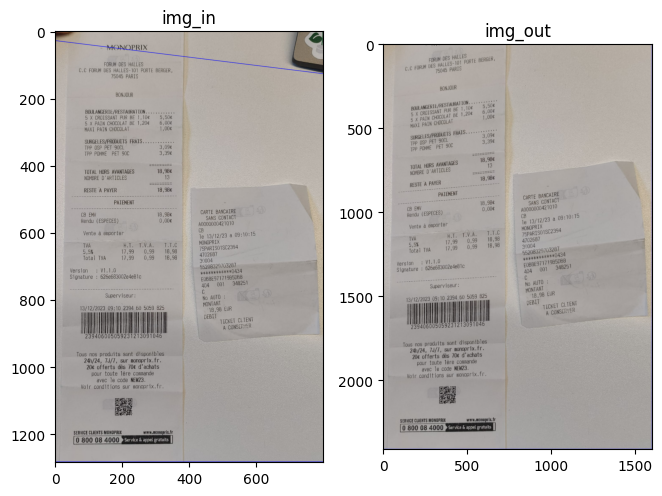

In [32]:
filename = root_dir / r'data\casino.jpg'

img_in = cv2.cvtColor(resize(cv2.imread(str(filename))),cv2.COLOR_BGR2RGB)
img_out = advanced_receipt_segmentation(img_in)
display_result((img_in, img_out),('img_in', 'img_out'))

## 3) Canny Filtering and Hough Transform-Based Segmentation

For this scenario, the non-contrastive background presents a challenge for the previously discussed approach primarily because the lack of contrast between the receipt and the background hinders the effectiveness of thresholding-based techniques. In such cases, traditional methods like canny filtering and Hough transform tend to be more suitable. These techniques excel in detecting edges and lines within an image, irrespective of the background texture or color. By leveraging edge detection and line extraction, canny filtering and Hough transform can effectively isolate the receipt from the uniform background, thereby enabling accurate segmentation even in challenging environments.

In [33]:
def hough_receipt_segmentation(img_in):
    # img = cv2.GaussianBlur(img, (3,3), 0)

    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, 
        (5, 5)
    )

    img = cv2.morphologyEx(
        img_in, 
        cv2.MORPH_CLOSE, 
        kernel,
        iterations = 5
    )
    img = cv2.convertScaleAbs(img)
    img = cv2.Canny(img, 20, 100, apertureSize = 3)

    img_out = img_in.copy()
    lines = cv2.HoughLines(img, 1, np.pi / 90, 100, None, 0, 0)
    if lines is not None:
            for i in range(0, len(lines)):
                rho = lines[i][0][0]
                theta = lines[i][0][1]
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a)))
                pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a)))
                cv2.line(img_out, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    return img_out

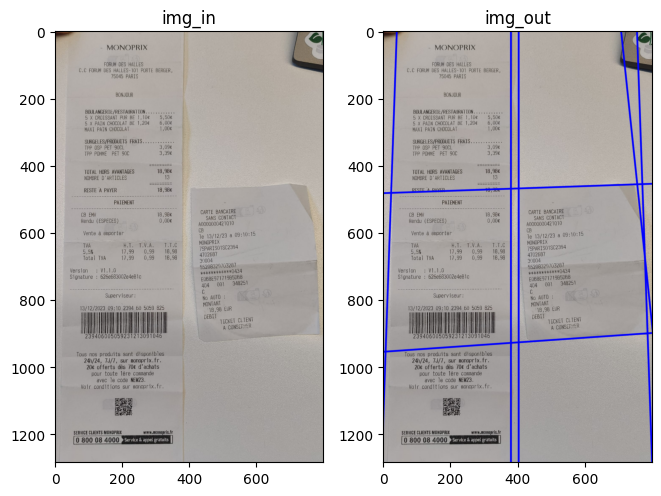

<Figure size 640x480 with 0 Axes>

In [40]:
filename = root_dir / r'data\casino.jpg'

img_in = resize(cv2.imread(str(filename)))
img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)

img_out = hough_receipt_segmentation(img_in)
display_result((img_in, img_out),('img_in', 'img_out'))

Note: While the Hough transform lacks the capability to provide coordinates of points contributing to the line, its probabilistic variant (HoughLineP) does offer this feature. However, the probabilistic variant did not yield optimal results in segmentation. How can we effectively leverage the strengths of both approaches?

## 4) Conclusion and Future Perspectives

Exploring the receipt segmentation problem has been both enlightening and challenging. While the inherent structure of receipts with known colors and shapes simplifies certain aspects, the variability in backgrounds poses significant hurdles. Backgrounds can range from highly detailed, complicating techniques like Hough transform, to low-contrast, challenging color-based thresholding methods.

To achieve a production-grade receipt segmentation, two main approaches could be considered. Firstly, gaining a deeper understanding of the prevalent types of receipt images could lead to tailored solutions for each category. Alternatively, developing a hybrid function that intelligently combines multiple segmentation techniques might provide a more robust and adaptable solution.

Furthermore, enhancing the performance of segmentation algorithms would require a more extensive dataset for fine-tuning hyperparameters. One potential avenue for this is leveraging the hyperopt library to optimize parameters, possibly using a scoring function such as Mean Squared Error (MSE) on corners' coordinates, accounting for permutations.